In [1]:
# read data from data set
from utils.data_utils import jigsaw_toxix_ds_get_df
import numpy as np
from config import *
df = jigsaw_toxix_ds_get_df()
comments = df["comment_text"].tolist()
comments = [x.replace('\n', ' ') for x in comments]

labels = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
dump_text = '\n'.join(comments)
total_classes = 6
class_matrix = df[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].astype('int')
label_matrix = class_matrix.values
h_dim = 300


In [2]:
# load word2vec model
import os 
from config import model_folder
from model_factory.embeddings.w2v import w2v_load_from_keyedvectors, build_embedding_layer
w2v_name = 'google_keyed_vector_format.bin'
model_path = os.path.join(model_folder, w2v_name)
    
w2v_model = w2v_load_from_keyedvectors(model_path)
vocab = w2v_model.vocab

word_2_idx = dict(zip(vocab.keys(), range(len(vocab))))
max_sent_length = 80
trainable = False


Using TensorFlow backend.


In [5]:
# tokenization
import nltk
from keras.preprocessing.sequence import pad_sequences



def tokenizer(text, word2idx, max_len=80, total=None):
    if total is not None:
        text = text[:total]
    for sentence_idx in range(len(text)):
        sentence = text[sentence_idx]
        text[sentence_idx] = nltk.word_tokenize(sentence)
 
    def _sent_to_idx(s, w2i):
        for word_idx in range(len(s)):
            word = s[word_idx]
            idx = w2i.get(word, w2i['null'])
            s[word_idx] = idx
        return s
        
    for sentence_idx in range(len(text)):
        sentence = text[sentence_idx]
        sequence = _sent_to_idx(sentence, word2idx)
        text[sentence_idx] = sequence
    
    text = pad_sequences(text, maxlen=max_len, value=word2idx['null'])   
    return text

num_samples = 1000
tokenized_sequence = tokenizer(comments, word_2_idx, max_sent_length, total=num_samples)
if num_samples is not None:
    label_matrix = label_matrix[:num_samples]


In [4]:
# build dummy model
import tensorflow as tf
from keras import models, layers, objectives, metrics
with tf.device('/cpu:0'):
    embedding_layer = build_embedding_layer(w2v_model, word_2_idx, len(vocab), max_sent_length, trainable)
    print(embedding_layer)
    dummy_m = models.Sequential()
    dummy_m.add(embedding_layer)
    dummy_m.add(layers.LSTM(
        units=h_dim, 
        return_sequences=True,
        dropout=0.5,
    ))
    dummy_m.add(layers.LSTM(
        units=h_dim, 
        return_sequences=False,
        dropout=0.5,
    ))
    dummy_m.add(layers.Dense(total_classes, activation='sigmoid'))
    dummy_m.compile(optimizer='adam', loss=objectives.binary_crossentropy, metrics=[metrics.top_k_categorical_accuracy])
print(len(tokenized_sequence), len(label_matrix))



1000 1000


In [8]:
# fit dummy model
train_test_split = 0.2
dummy_m.fit(tokenized_sequence, label_matrix, epochs=1, batch_size=1024,
            validation_split=train_test_split)

Train on 800 samples, validate on 200 samples
Epoch 1/1


800/800 [==============================] - 2s 2ms/step - loss: 0.6958 - top_k_categorical_accuracy: 0.8650 - val_loss: 0.6421 - val_top_k_categorical_accuracy: 1.0000


In [13]:
train_test_split=0.1
divider = int(len(tokenized_sequence)*train_test_split)

test_X = tokenized_sequence[-divider:]
test_Y = label_matrix[-divider:]
pred_Y = dummy_m.predict(test_X,)
topic_Y = test_Y.T
pred_topic_Y = pred_Y.T

In [16]:
# evaluate performance
threshold = 0.5
print(threshold)
from sklearn.metrics.classification import precision_score, recall_score
print(','.join(['sample size','precision','recall', 'prior']))
# print(pred_topic_Y[0].tolist())
for topic_idx in range(len(pred_topic_Y)):
    true_topic = topic_Y[topic_idx]
    pred_topic = pred_topic_Y[topic_idx]
    pred_topic[np.where(pred_topic >= threshold)] = 1
    pred_topic[np.where(pred_topic < threshold)] = 0
    print('%d, %.2f, %.2f, %.2f' % (sum(true_topic), precision_score(true_topic, pred_topic), recall_score(true_topic, pred_topic), sum(true_topic)/len(true_topic)))

0.5
sample size,precision,recall,prior
10, 0.00, 0.00, 0.10
0, 0.00, 0.00, 0.00
3, 0.00, 0.00, 0.03
0, 0.00, 0.00, 0.00
5, 0.00, 0.00, 0.05
1, 0.00, 0.00, 0.01


/home/pintellect/anaconda3/envs/ml-dev/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [17]:
# bayes network

from model_factory.lstm_mc_dropout import SeqCLS

embedding_layer = build_embedding_layer(w2v_model, word_2_idx, 
                                        len(vocab), max_sent_length, trainable)

m = SeqCLS()
m.configure(None, 
            max_sent_length, 
            total_classes, 300, 
            pretrained_embedding=embedding_layer,
            # verbose=1,
            )




InternalError: Dst tensor is not initialized.
	 [[Node: _arg_embedding_4/Placeholder_0_0/_357 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_6__arg_embedding_4/Placeholder_0_0", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

In [7]:
# run this block multiple times retrain the same model `m` if `m` if not initialized in this block
epochs=1
# join embeddings with data set dataframe
train_test_split = 0.2
m.fit(tokenized_sequence, label_matrix, epochs=epochs, batch_size=1024, 
      validation_split=train_test_split)

Train on 800 samples, validate on 200 samples
Epoch 1/1


800/800 [==============================] - 6s 8ms/step - loss: 0.8313 - val_loss: 0.6031


In [ ]:

train_test_split=0.1
divider = int(len(tokenized_sequence)*train_test_split)

test_X = tokenized_sequence[-divider:]
test_Y = label_matrix[-divider:]
pred_Y, uncertainty_Y = m.predict_with_uncertainty(test_X, sim=10)
topic_Y = test_Y.T
pred_topic_Y = pred_Y.T


In [ ]:
# evaluate performance
threshold = 0.5
print(threshold)
from sklearn.metrics.classification import precision_score, recall_score
print(','.join(['sample size','precision','recall', 'prior']))
# print(pred_topic_Y[0].tolist())
for topic_idx in range(len(pred_topic_Y)):
    true_topic = topic_Y[topic_idx]
    pred_topic = pred_topic_Y[topic_idx]
    pred_topic[np.where(pred_topic >= threshold)] = 1
    pred_topic[np.where(pred_topic < threshold)] = 0
    print('%d, %.2f, %.2f, %.2f' 
          % (sum(true_topic), 
             precision_score(true_topic, pred_topic, average='binary'), 
             recall_score(true_topic, pred_topic), 
             sum(true_topic)/len(true_topic)))


0.5
sample size,precision,recall,prior
10, 0.09, 0.50, 0.10
0, 0.00, 0.00, 0.00
3, 0.00, 0.00, 0.03
0, 0.00, 0.00, 0.00
5, 0.10, 0.60, 0.05
1, 0.03, 1.00, 0.01


/home/pintellect/anaconda3/envs/ml-dev/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
# sampling from model

# train_test_split=0.1
# divider = int(len(tokenized_sequence)*train_test_split)
divider = 10
r = -130
l = -140
test_X = tokenized_sequence[l:r]
test_Y = label_matrix[l:r]
test_comments = comments[l:r]
print(comments[0])
samples = m.sample_output(test_X, n_iter=100)
print(samples.shape)


NameError: name 'tokenized_sequence' is not defined

(100, 10, 6)
(6, 10, 100)
toxic
"  I'm sorry; I was lazy.  Here's where I got the information about the diphthongal variants  of , and they make it clear in the references that Wells (1982a) is Wells, J.C. Accents of English 1: An Introduction.  Cambridge: Cambridge University Press.  They also say Cruttenden (2001) is Cruttenden, A. (2001) Gimson's Pronunciation of English. 6th edn. London: Arnold.  A Handbook of Varieties of English (Bernd Kortmann, Edgar W. Schneider, Walter de Gruyter, 2004) is where I got the information about  monophthongization in Cockney; they, in turn, referenced Wells (1982).  In this case, ""Wells (1982: 309)"" refers to Wells, J.C. Accents of English 2  The British Isles. Cambridge: Cambridge University Press.  There you go.   "


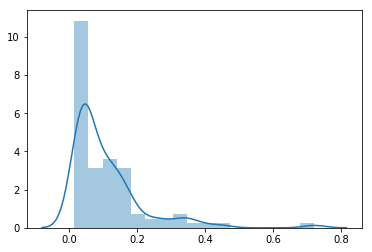

toxic
Hmm, thanks. But it's a nasty hack really ... — Martin ( · talk)


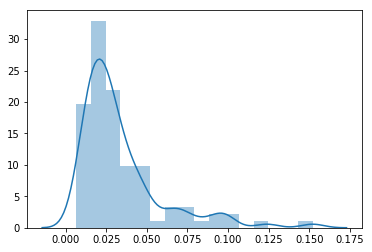

toxic
" I understand you, but you also should understand me. You shouldn't revert my work. As you can see, I don't disrupt your edits at articles Draza Mihailovic, Josip Broz Tito, or at Template:Yugoslav Axis collaborationism. I realy respect your effort and work there, and I don't revert it. I have no desire to get blocked, or to drag you into another blockade. I want to resolve all this disputes with you. As you can see I already changed Template:Politics of Yugoslavia to a neutral, non-image version. These are my proposals to you:  1) If we put in place your version of the list of Yugoslav Prime Ministers, it will remove Drago Marusic as Prime Minister in 1945, between Ivan Subasic and Tito. If you agree to left him on the list, this dispute is over. If we agree about Marusic, we can also agree about the issue ""Kingdom or DF Yugoslavia"".  2) Federal Republic of Yugoslavia was a complete different state than Serbia and Montenegro. It wasn't like Kingdom of Serbs, Croats and Sloven

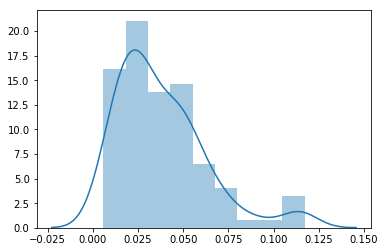

toxic
William Wilberforce   No worries. I had noticed the question of attribution, and had a look at the Ferens site before uploading, but saw nothing about the issue. I hadn't thought to look on the Talk page. Thanks for letting me know. Regards,


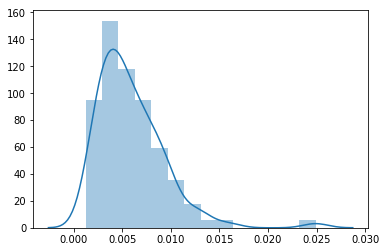

toxic
you gotta let somebody love you.


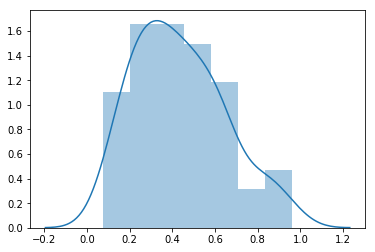

toxic
"  Great peace-keeping! That solved the problem in my opinion.  ™ "


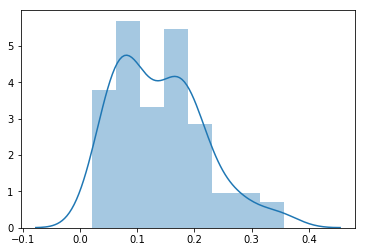

toxic
Hi  Sometimes you are wright! Sometimes I am rihgt!  Sometimes we are wright.


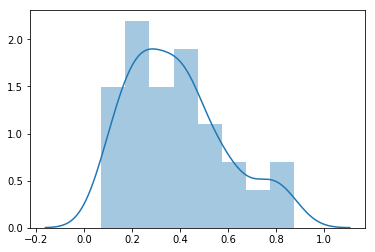

toxic
Yeah i no it sucks.


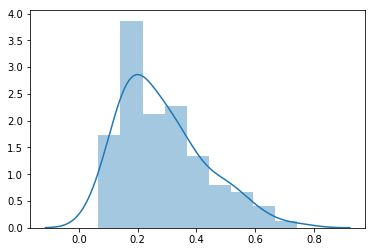

toxic
I think he is a gay fag!!!


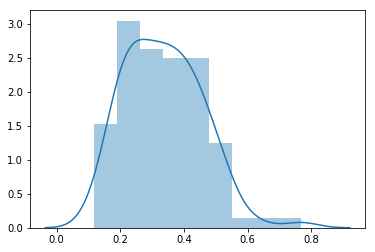

toxic
Seems likely from their descriptions.


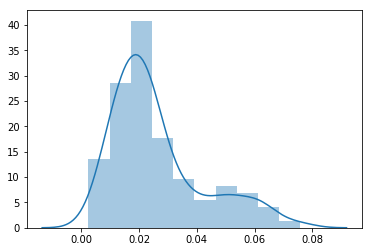

severe_toxic
"  I'm sorry; I was lazy.  Here's where I got the information about the diphthongal variants  of , and they make it clear in the references that Wells (1982a) is Wells, J.C. Accents of English 1: An Introduction.  Cambridge: Cambridge University Press.  They also say Cruttenden (2001) is Cruttenden, A. (2001) Gimson's Pronunciation of English. 6th edn. London: Arnold.  A Handbook of Varieties of English (Bernd Kortmann, Edgar W. Schneider, Walter de Gruyter, 2004) is where I got the information about  monophthongization in Cockney; they, in turn, referenced Wells (1982).  In this case, ""Wells (1982: 309)"" refers to Wells, J.C. Accents of English 2  The British Isles. Cambridge: Cambridge University Press.  There you go.   "


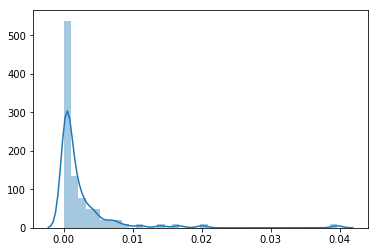

severe_toxic
Hmm, thanks. But it's a nasty hack really ... — Martin ( · talk)


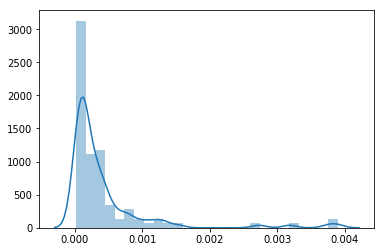

severe_toxic
" I understand you, but you also should understand me. You shouldn't revert my work. As you can see, I don't disrupt your edits at articles Draza Mihailovic, Josip Broz Tito, or at Template:Yugoslav Axis collaborationism. I realy respect your effort and work there, and I don't revert it. I have no desire to get blocked, or to drag you into another blockade. I want to resolve all this disputes with you. As you can see I already changed Template:Politics of Yugoslavia to a neutral, non-image version. These are my proposals to you:  1) If we put in place your version of the list of Yugoslav Prime Ministers, it will remove Drago Marusic as Prime Minister in 1945, between Ivan Subasic and Tito. If you agree to left him on the list, this dispute is over. If we agree about Marusic, we can also agree about the issue ""Kingdom or DF Yugoslavia"".  2) Federal Republic of Yugoslavia was a complete different state than Serbia and Montenegro. It wasn't like Kingdom of Serbs, Croats and

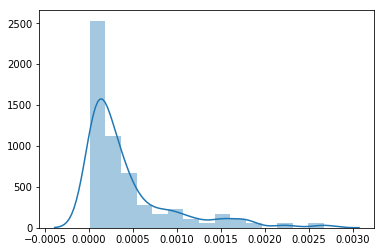

severe_toxic
William Wilberforce   No worries. I had noticed the question of attribution, and had a look at the Ferens site before uploading, but saw nothing about the issue. I hadn't thought to look on the Talk page. Thanks for letting me know. Regards,


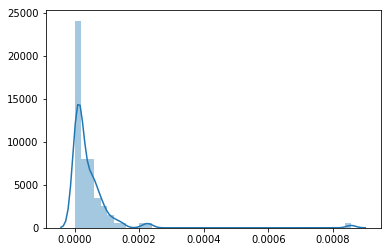

severe_toxic
you gotta let somebody love you.


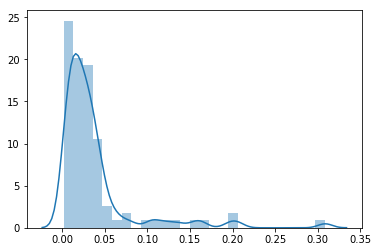

severe_toxic
"  Great peace-keeping! That solved the problem in my opinion.  ™ "


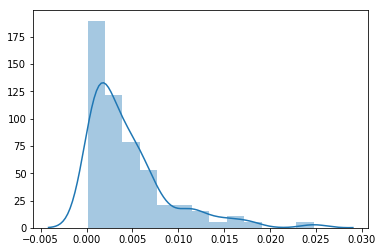

severe_toxic
Hi  Sometimes you are wright! Sometimes I am rihgt!  Sometimes we are wright.


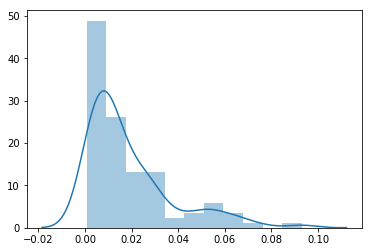

severe_toxic
Yeah i no it sucks.


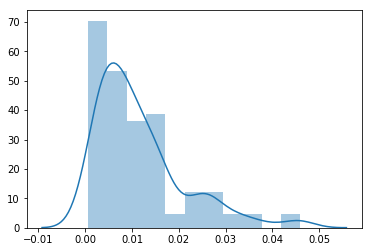

severe_toxic
I think he is a gay fag!!!


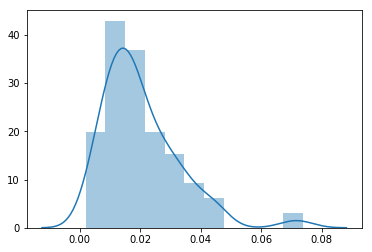

severe_toxic
Seems likely from their descriptions.


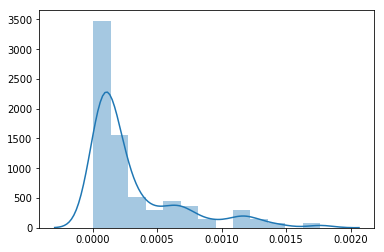

obscene
"  I'm sorry; I was lazy.  Here's where I got the information about the diphthongal variants  of , and they make it clear in the references that Wells (1982a) is Wells, J.C. Accents of English 1: An Introduction.  Cambridge: Cambridge University Press.  They also say Cruttenden (2001) is Cruttenden, A. (2001) Gimson's Pronunciation of English. 6th edn. London: Arnold.  A Handbook of Varieties of English (Bernd Kortmann, Edgar W. Schneider, Walter de Gruyter, 2004) is where I got the information about  monophthongization in Cockney; they, in turn, referenced Wells (1982).  In this case, ""Wells (1982: 309)"" refers to Wells, J.C. Accents of English 2  The British Isles. Cambridge: Cambridge University Press.  There you go.   "


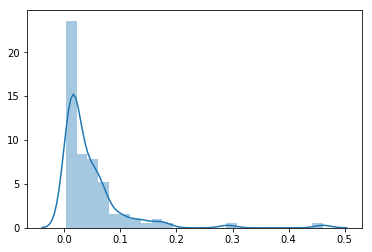

obscene
Hmm, thanks. But it's a nasty hack really ... — Martin ( · talk)


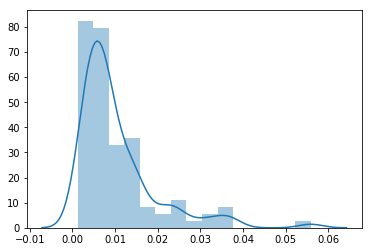

obscene
" I understand you, but you also should understand me. You shouldn't revert my work. As you can see, I don't disrupt your edits at articles Draza Mihailovic, Josip Broz Tito, or at Template:Yugoslav Axis collaborationism. I realy respect your effort and work there, and I don't revert it. I have no desire to get blocked, or to drag you into another blockade. I want to resolve all this disputes with you. As you can see I already changed Template:Politics of Yugoslavia to a neutral, non-image version. These are my proposals to you:  1) If we put in place your version of the list of Yugoslav Prime Ministers, it will remove Drago Marusic as Prime Minister in 1945, between Ivan Subasic and Tito. If you agree to left him on the list, this dispute is over. If we agree about Marusic, we can also agree about the issue ""Kingdom or DF Yugoslavia"".  2) Federal Republic of Yugoslavia was a complete different state than Serbia and Montenegro. It wasn't like Kingdom of Serbs, Croats and Slov

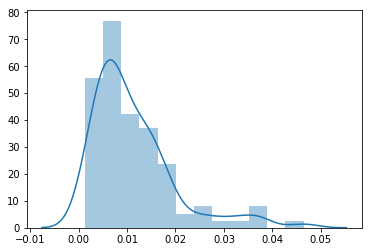

obscene
William Wilberforce   No worries. I had noticed the question of attribution, and had a look at the Ferens site before uploading, but saw nothing about the issue. I hadn't thought to look on the Talk page. Thanks for letting me know. Regards,


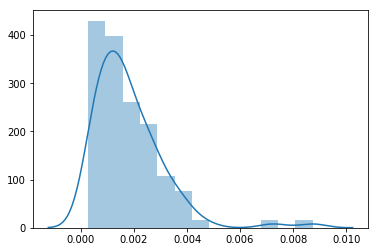

obscene
you gotta let somebody love you.


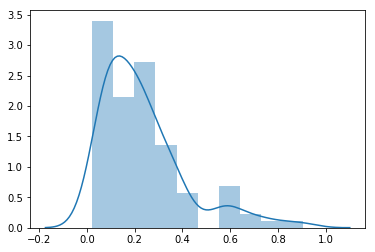

obscene
"  Great peace-keeping! That solved the problem in my opinion.  ™ "


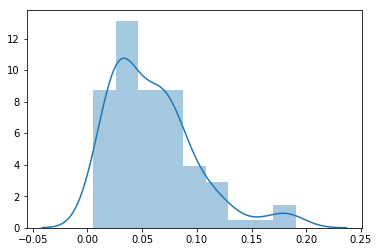

obscene
Hi  Sometimes you are wright! Sometimes I am rihgt!  Sometimes we are wright.


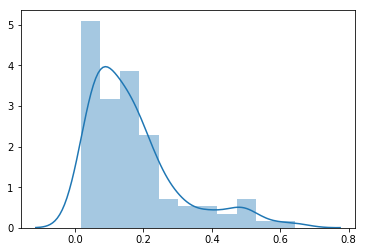

obscene
Yeah i no it sucks.


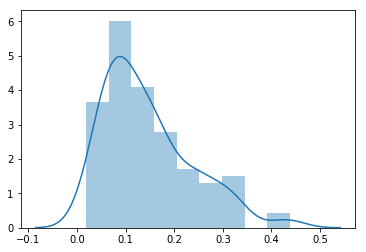

obscene
I think he is a gay fag!!!


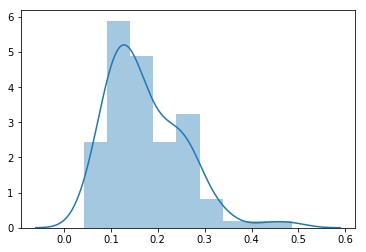

obscene
Seems likely from their descriptions.


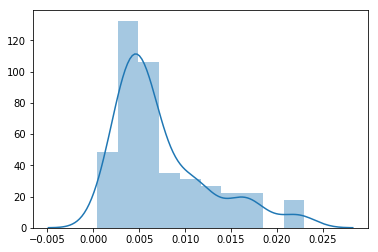

threat
"  I'm sorry; I was lazy.  Here's where I got the information about the diphthongal variants  of , and they make it clear in the references that Wells (1982a) is Wells, J.C. Accents of English 1: An Introduction.  Cambridge: Cambridge University Press.  They also say Cruttenden (2001) is Cruttenden, A. (2001) Gimson's Pronunciation of English. 6th edn. London: Arnold.  A Handbook of Varieties of English (Bernd Kortmann, Edgar W. Schneider, Walter de Gruyter, 2004) is where I got the information about  monophthongization in Cockney; they, in turn, referenced Wells (1982).  In this case, ""Wells (1982: 309)"" refers to Wells, J.C. Accents of English 2  The British Isles. Cambridge: Cambridge University Press.  There you go.   "


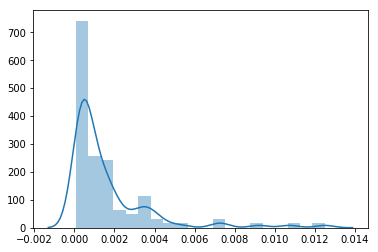

threat
Hmm, thanks. But it's a nasty hack really ... — Martin ( · talk)


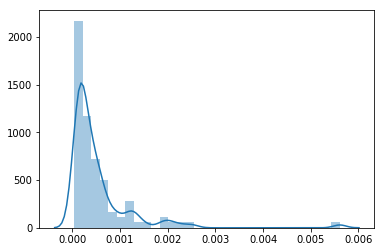

threat
" I understand you, but you also should understand me. You shouldn't revert my work. As you can see, I don't disrupt your edits at articles Draza Mihailovic, Josip Broz Tito, or at Template:Yugoslav Axis collaborationism. I realy respect your effort and work there, and I don't revert it. I have no desire to get blocked, or to drag you into another blockade. I want to resolve all this disputes with you. As you can see I already changed Template:Politics of Yugoslavia to a neutral, non-image version. These are my proposals to you:  1) If we put in place your version of the list of Yugoslav Prime Ministers, it will remove Drago Marusic as Prime Minister in 1945, between Ivan Subasic and Tito. If you agree to left him on the list, this dispute is over. If we agree about Marusic, we can also agree about the issue ""Kingdom or DF Yugoslavia"".  2) Federal Republic of Yugoslavia was a complete different state than Serbia and Montenegro. It wasn't like Kingdom of Serbs, Croats and Slove

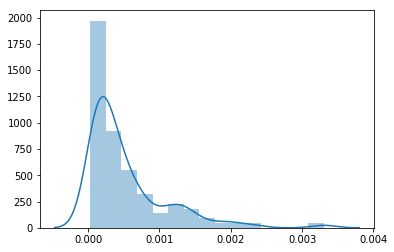

threat
William Wilberforce   No worries. I had noticed the question of attribution, and had a look at the Ferens site before uploading, but saw nothing about the issue. I hadn't thought to look on the Talk page. Thanks for letting me know. Regards,


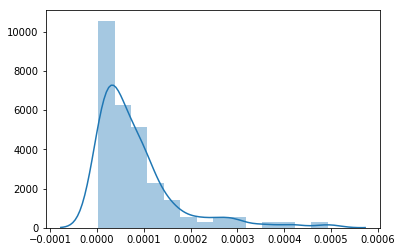

threat
you gotta let somebody love you.


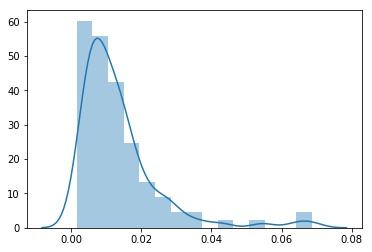

threat
"  Great peace-keeping! That solved the problem in my opinion.  ™ "


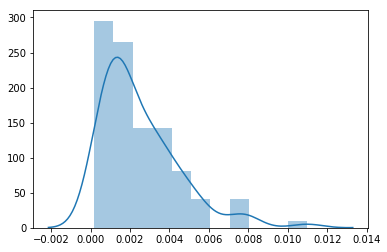

threat
Hi  Sometimes you are wright! Sometimes I am rihgt!  Sometimes we are wright.


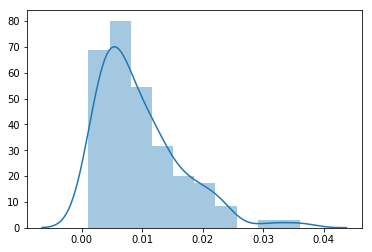

threat
Yeah i no it sucks.


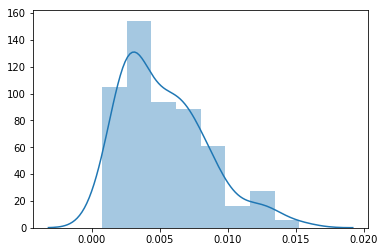

threat
I think he is a gay fag!!!


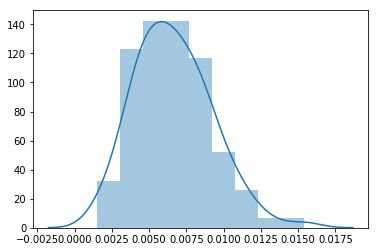

threat
Seems likely from their descriptions.


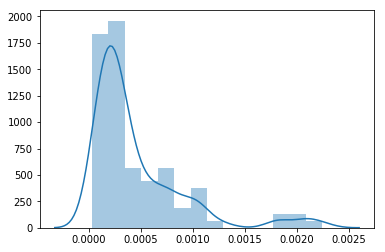

insult
"  I'm sorry; I was lazy.  Here's where I got the information about the diphthongal variants  of , and they make it clear in the references that Wells (1982a) is Wells, J.C. Accents of English 1: An Introduction.  Cambridge: Cambridge University Press.  They also say Cruttenden (2001) is Cruttenden, A. (2001) Gimson's Pronunciation of English. 6th edn. London: Arnold.  A Handbook of Varieties of English (Bernd Kortmann, Edgar W. Schneider, Walter de Gruyter, 2004) is where I got the information about  monophthongization in Cockney; they, in turn, referenced Wells (1982).  In this case, ""Wells (1982: 309)"" refers to Wells, J.C. Accents of English 2  The British Isles. Cambridge: Cambridge University Press.  There you go.   "


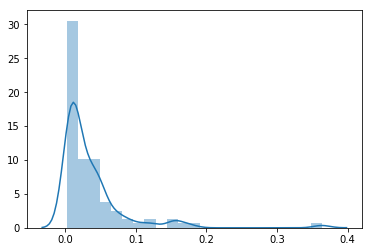

insult
Hmm, thanks. But it's a nasty hack really ... — Martin ( · talk)


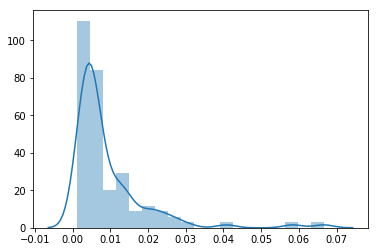

insult
" I understand you, but you also should understand me. You shouldn't revert my work. As you can see, I don't disrupt your edits at articles Draza Mihailovic, Josip Broz Tito, or at Template:Yugoslav Axis collaborationism. I realy respect your effort and work there, and I don't revert it. I have no desire to get blocked, or to drag you into another blockade. I want to resolve all this disputes with you. As you can see I already changed Template:Politics of Yugoslavia to a neutral, non-image version. These are my proposals to you:  1) If we put in place your version of the list of Yugoslav Prime Ministers, it will remove Drago Marusic as Prime Minister in 1945, between Ivan Subasic and Tito. If you agree to left him on the list, this dispute is over. If we agree about Marusic, we can also agree about the issue ""Kingdom or DF Yugoslavia"".  2) Federal Republic of Yugoslavia was a complete different state than Serbia and Montenegro. It wasn't like Kingdom of Serbs, Croats and Slove

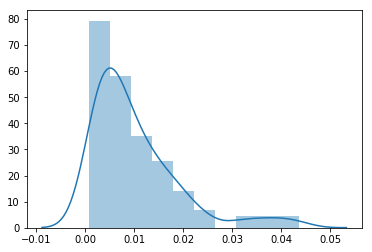

insult
William Wilberforce   No worries. I had noticed the question of attribution, and had a look at the Ferens site before uploading, but saw nothing about the issue. I hadn't thought to look on the Talk page. Thanks for letting me know. Regards,


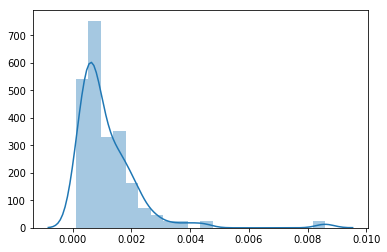

insult
you gotta let somebody love you.


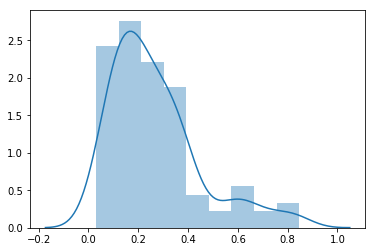

insult
"  Great peace-keeping! That solved the problem in my opinion.  ™ "


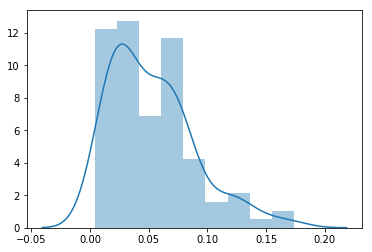

insult
Hi  Sometimes you are wright! Sometimes I am rihgt!  Sometimes we are wright.


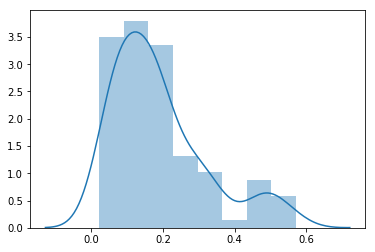

insult
Yeah i no it sucks.


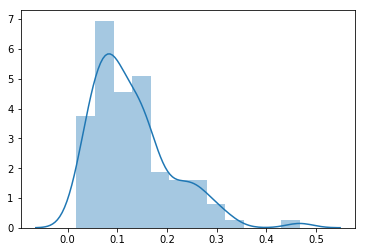

insult
I think he is a gay fag!!!


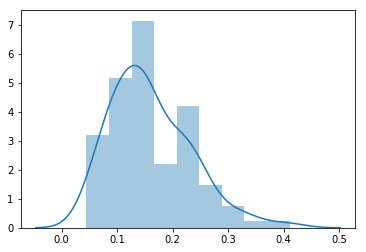

insult
Seems likely from their descriptions.


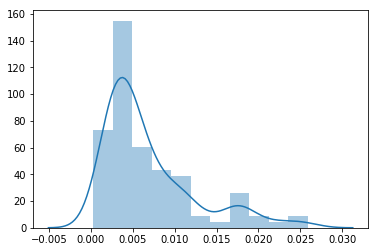

identity_hate
"  I'm sorry; I was lazy.  Here's where I got the information about the diphthongal variants  of , and they make it clear in the references that Wells (1982a) is Wells, J.C. Accents of English 1: An Introduction.  Cambridge: Cambridge University Press.  They also say Cruttenden (2001) is Cruttenden, A. (2001) Gimson's Pronunciation of English. 6th edn. London: Arnold.  A Handbook of Varieties of English (Bernd Kortmann, Edgar W. Schneider, Walter de Gruyter, 2004) is where I got the information about  monophthongization in Cockney; they, in turn, referenced Wells (1982).  In this case, ""Wells (1982: 309)"" refers to Wells, J.C. Accents of English 2  The British Isles. Cambridge: Cambridge University Press.  There you go.   "


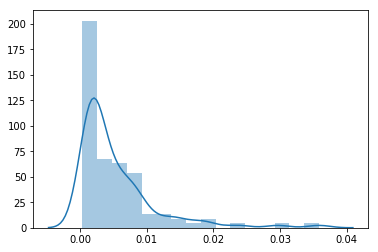

identity_hate
Hmm, thanks. But it's a nasty hack really ... — Martin ( · talk)


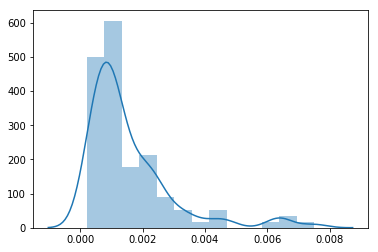

identity_hate
" I understand you, but you also should understand me. You shouldn't revert my work. As you can see, I don't disrupt your edits at articles Draza Mihailovic, Josip Broz Tito, or at Template:Yugoslav Axis collaborationism. I realy respect your effort and work there, and I don't revert it. I have no desire to get blocked, or to drag you into another blockade. I want to resolve all this disputes with you. As you can see I already changed Template:Politics of Yugoslavia to a neutral, non-image version. These are my proposals to you:  1) If we put in place your version of the list of Yugoslav Prime Ministers, it will remove Drago Marusic as Prime Minister in 1945, between Ivan Subasic and Tito. If you agree to left him on the list, this dispute is over. If we agree about Marusic, we can also agree about the issue ""Kingdom or DF Yugoslavia"".  2) Federal Republic of Yugoslavia was a complete different state than Serbia and Montenegro. It wasn't like Kingdom of Serbs, Croats an

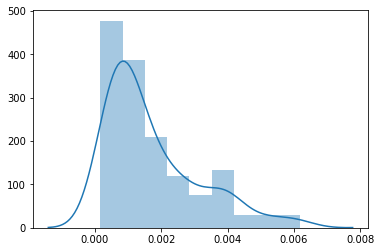

identity_hate
William Wilberforce   No worries. I had noticed the question of attribution, and had a look at the Ferens site before uploading, but saw nothing about the issue. I hadn't thought to look on the Talk page. Thanks for letting me know. Regards,


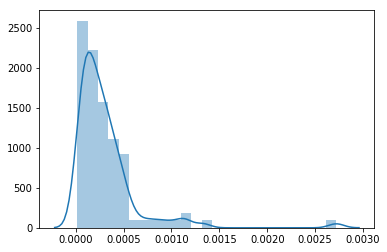

identity_hate
you gotta let somebody love you.


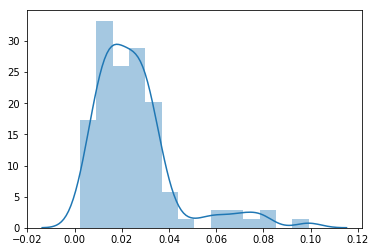

identity_hate
"  Great peace-keeping! That solved the problem in my opinion.  ™ "


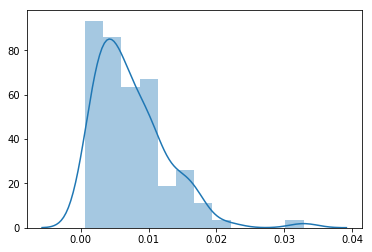

identity_hate
Hi  Sometimes you are wright! Sometimes I am rihgt!  Sometimes we are wright.


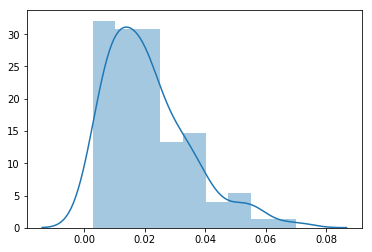

identity_hate
Yeah i no it sucks.


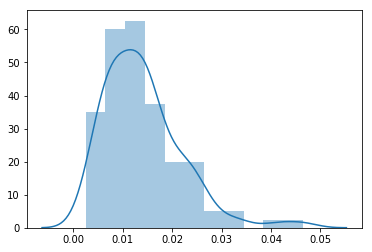

identity_hate
I think he is a gay fag!!!


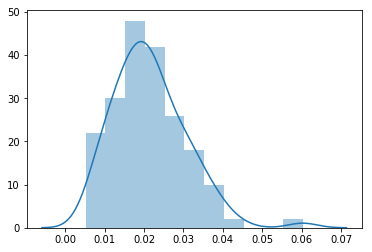

identity_hate
Seems likely from their descriptions.


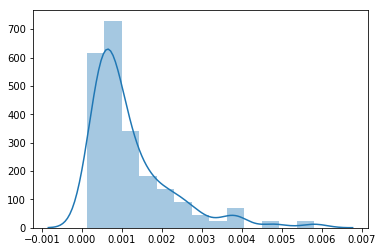

<Figure size 432x288 with 0 Axes>

In [79]:

sample_cpy = np.array(samples)
print(sample_cpy.shape)
sample_cpy = np.swapaxes(sample_cpy, 0, -1)
print(sample_cpy.shape)

import seaborn as sns
import matplotlib.pyplot as plt

for topic_idx in range(sample_cpy.shape[0]):
    for data_idx in range(sample_cpy.shape[1]):
        sim_samples = sample_cpy[topic_idx][data_idx]
        sns.distplot(sim_samples)
        print(labels[topic_idx])
        print(test_comments[data_idx])
        plt.show();plt.close();plt.cla();plt.clf()